In [88]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [48]:
train_file='filled_merged_train.xlsx'
test_file='filled_merged_test.xlsx'
df_train=pd.read_excel(train_file)
df_test=pd.read_excel(test_file)

In [49]:
df_train.shape

(246, 16)

In [50]:
# 准备特征和目标
X = df_train.iloc[:, :-2].values
y = df_train.iloc[:, -2:].values
target_names = df_train.columns[-2:].tolist()


In [51]:
X.shape
y


array([[ 2.36  , 32.    ],
       [ 5.42  , 28.5   ],
       [ 9.31  , 23.75  ],
       [13.29  , 19.2   ],
       [17.56  , 14.9   ],
       [22.11  , 12.    ],
       [25.4   ,  6.8   ],
       [29.26  ,  1.82  ],
       [29.9853,  3.5426],
       [ 4.71  , 31.75  ],
       [ 9.41  , 26.75  ],
       [15.62  , 24.4   ],
       [19.51  , 19.8   ],
       [22.69  , 15.6   ],
       [25.55  , 11.7   ],
       [26.88  ,  6.1   ],
       [30.86  ,  1.82  ],
       [30.5846,  3.7567],
       [ 3.88  , 45.6   ],
       [ 8.01  , 29.    ],
       [12.86  , 25.25  ],
       [17.04  , 19.75  ],
       [20.74  , 13.5   ],
       [24.02  ,  9.2   ],
       [26.07  ,  7.05  ],
       [29.66  ,  3.3   ],
       [30.46  ,  1.7   ],
       [30.1659,  3.4256],
       [ 1.4   , 31.75  ],
       [ 6.77  , 29.    ],
       [11.62  , 25.5   ],
       [16.61  , 22.8   ],
       [20.58  , 18.8   ],
       [25.63  , 13.5   ],
       [27.47  ,  7.    ],
       [31.74  ,  1.88  ],
       [30.8957,  4.0154],
 

In [52]:
# # 查找字符
# import pandas as pd
# import numpy as np

# df = df_train
# # 定义函数检查是否为非数字字符
# def is_non_numeric(x):
#     # 检查是否为字符串
#     if isinstance(x, str):
#         # 尝试转换为浮点数，如果失败则是非数字
#         return True   # 不能转换为数字
#     # 如果是数字类型，返回False
#     elif isinstance(x, (int, float)):
#         return False
#     # 如果是None或NaN，不算非数字字符
#     elif pd.isna(x):
#         return False
#     # 其他类型（如日期、布尔等）
#     else:
#         return True

# # 创建一个空列表来存储非数字字符的位置和值
# non_numeric_positions = []

# # 遍历DataFrame的每个单元格
# for row_idx, row in df.iterrows():
#     for col_idx, value in row.items():
#         if is_non_numeric(value):
#             # 将行索引、列名和值添加到列表中
#             non_numeric_positions.append({
#                 'row': row_idx + 1,  # 加1是为了匹配Excel的行号
#                 'column': col_idx,
#                 'value': value
#             })
# # 打印结果
# if non_numeric_positions:
#     print(f"找到 {len(non_numeric_positions)} 个非数字字符:")
#     for pos in non_numeric_positions:
#         print(f"行 {pos['row']}, 列 '{pos['column']}': {pos['value']}")
# else:
#     print("未找到非数字字符")

In [53]:

# 数据标准化
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

In [54]:

# 修改创建序列的函数，每9行为一组，不重叠
def create_sequences(X, y, seq_length=9):
    X_seq, y_seq = [], []
    for i in range(0, len(X), seq_length):
        if i + seq_length <= len(X):
            X_seq.append(X[i:i+seq_length])
            y_seq.append(y[i:i+seq_length])
    return np.array(X_seq), np.array(y_seq)


In [55]:
X_seq.shape

(27, 9, 14)

In [56]:

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:

class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # 返回所有时间步的预测
        predictions = self.fc(lstm_out)
        return predictions

# 设置参数
seq_length = 9  # 修改为9
input_size = X.shape[1]
hidden_size = 64
num_layers = 2
output_size = y.shape[1]
learning_rate = 0.001
batch_size = 1  # 修改为1，因为每个序列就是一个batch


In [58]:

# 创建序列数据
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)

# 创建数据加载器
dataset = TimeSeriesDataset(X_seq, y_seq)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


In [59]:
X_seq

array([[[0.        , 0.        , 0.        , ..., 0.03773585,
         0.84040259, 0.8962963 ],
        [0.11851852, 0.02092867, 0.04233721, ..., 0.03773585,
         0.82961898, 0.83703704],
        [0.23703704, 0.07328398, 0.11809854, ..., 0.03773585,
         0.79798706, 0.83407407],
        ...,
        [0.71111111, 0.21985195, 0.53131963, ..., 0.03773585,
         0.59741193, 0.88740741],
        [0.82962963, 0.34017497, 0.61277544, ..., 0.03773585,
         0.54780733, 0.8962963 ],
        [0.96444444, 0.44858681, 0.70834365, ..., 0.01886792,
         0.49101366, 0.91111111]],

       [[0.        , 0.02018843, 0.02896757, ..., 0.03773585,
         0.48813803, 0.85185185],
        [0.11851852, 0.01716016, 0.10051993, ..., 0.03773585,
         0.465133  , 0.85185185],
        [0.23703704, 0.02543742, 0.21688537, ..., 0.03773585,
         0.42271747, 0.86074074],
        ...,
        [0.71111111, 0.462786  , 0.61648923, ..., 0.03773585,
         0.22861251, 0.91407407],
        [0.8

In [60]:
for i in dataset:   
    print(i)
    break

(tensor([[0.0000, 0.0000, 0.0000, 0.9638, 0.0000, 0.0230, 0.6929, 0.0452, 0.4000,
         0.9766, 0.3697, 0.0377, 0.8404, 0.8963],
        [0.1185, 0.0209, 0.0423, 0.9059, 0.1304, 0.0334, 0.6857, 0.0433, 0.4000,
         0.9766, 0.3388, 0.0377, 0.8296, 0.8370],
        [0.2370, 0.0733, 0.1181, 0.8046, 0.2826, 0.0439, 0.6643, 0.0442, 0.4000,
         0.9766, 0.1834, 0.0377, 0.7980, 0.8341],
        [0.3556, 0.1439, 0.2144, 0.6671, 0.3261, 0.0405, 0.6643, 0.0442, 0.4000,
         0.9766, 0.1057, 0.0377, 0.7498, 0.8519],
        [0.4741, 0.2041, 0.3129, 0.5353, 0.3478, 0.0391, 0.6643, 0.0442, 0.4000,
         0.9766, 0.0706, 0.0377, 0.7024, 0.8578],
        [0.5926, 0.2131, 0.4187, 0.4108, 0.3913, 0.0401, 0.6643, 0.0442, 0.4000,
         0.9766, 0.0426, 0.0377, 0.6492, 0.8726],
        [0.7111, 0.2199, 0.5313, 0.3269, 0.4348, 0.0555, 0.6643, 0.0433, 0.4000,
         0.9766, 0.0267, 0.0377, 0.5974, 0.8874],
        [0.8296, 0.3402, 0.6128, 0.1763, 0.4348, 0.0571, 0.6571, 0.0433, 0.4000,
 

In [ ]:

# 初始化模型
model = LSTMPredictor(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 记录训练损失
losses = []

# 训练模型
best_loss = 99999
num_epochs = 500
scheduler = StepLR(optimizer, step_size=50, gamma=0.9)  # 每100个epoch学习率衰减为原来的0.9倍


for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    loss_epoch = 0
    for X_batch, y_batch in data_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss/len(data_loader)
    losses.append(avg_loss)
    if (epoch + 1) % 10 == 0:
        print(f'轮次 {epoch+1}/{num_epochs}, 损失: {avg_loss:.4f}')
    if optimizer.state_dict()['param_groups'][0]['lr'] > 2e-5:
        scheduler.step()
    if epoch == 0 or loss_epoch < best_loss:
        torch.save(model.state_dict(), 'model.pt')

# 预测
model.eval()
with torch.no_grad():
    X_tensor = torch.FloatTensor(X_seq)
    predictions = model(X_tensor)
    predictions = predictions.reshape(-1, output_size)
    predictions = y_scaler.inverse_transform(predictions.numpy())
    actual = y_seq.reshape(-1, output_size)
    actual = y_scaler.inverse_transform(actual)

    

In [76]:
plt.style.use('seaborn')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 在代码开头添加以下字体设置
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'Microsoft YaHei']  # 尝试多个中文字体
# 可视化训练过程
plt.figure(figsize=(12, 5))
plt.plot(losses)
plt.title('训练损失曲线')
plt.xlabel('训练轮次')
plt.ylabel('损失')
plt.savefig('training_loss.png')
plt.close()
# 预测结果对比折线图
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('预测结果对比')
# 创建时间序列索引
time_steps = np.arange(len(actual))

for i in range(2):
    # 绘制真实值
    axes[i].plot(time_steps, actual[:, i], 'b-', label='实际值', linewidth=2)
    # 绘制预测值
    axes[i].plot(time_steps, predictions[:, i], 'r--', label='预测值', linewidth=2)
    
    # 添加标题和标签
    axes[i].set_title(f'{target_names[i]}预测结果')
    axes[i].set_xlabel('时间步')
    axes[i].set_ylabel('值')
    axes[i].legend()
    axes[i].grid(True)

    # 添加网格
    axes[i].grid(True, linestyle='--', alpha=0.7)
    
    # 设置刻度
    axes[i].tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.savefig('prediction_results.png', dpi=300, bbox_inches='tight')
plt.close()

# 计算评估指标
mse = np.mean((predictions - actual) ** 2, axis=0)
mae = np.mean(np.abs(predictions - actual), axis=0)
mape = np.mean(np.abs((predictions - actual) / actual), axis=0) * 100

print("\n评估指标:")
for i in range(2):
    print(f"\n{target_names[i]}:")
    print(f"MSE: {mse[i]:.4f}")
    print(f"MAE: {mae[i]:.4f}")
    print(f"MAPE: {mape[i]:.2f}%")

/var/folders/6h/xbss61y56wnfzvzcm7k4524h0000gn/T/ipykernel_87765/591997946.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')



评估指标:

next_酸钠:
MSE: 0.3166
MAE: 0.4440
MAPE: inf%

next_残糖:
MSE: 0.5186
MAE: 0.5432
MAPE: inf%


/var/folders/6h/xbss61y56wnfzvzcm7k4524h0000gn/T/ipykernel_87765/591997946.py:46: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predictions - actual) / actual), axis=0) * 100


In [63]:
target_names

['next_酸钠', 'next_残糖']

In [100]:
# 处理预测数据
# 标准化测试数据（使用训练集的scaler）
X_test = df_test.iloc[:, :-2].values
y_test = df_test.iloc[:, -2:].values
X_test_scaled = X_scaler.fit_transform(X_test)
y_test_scaled = y_scaler.fit_transform(y_test)

In [ ]:
# X_seq_test, y_seq_test = create_sequences(X_test_scaled, y_test_scaled, seq_length)
# dataset_test = TimeSeriesDataset(X_seq_test, y_seq_test)
# data_loader_test = DataLoader(dataset_test, batch_size=3, shuffle=False)


In [116]:
input_size

14

In [ ]:
# 测试函数
def test_lstm_model(batch_size=1
                    ,X_test_scaled=X_test_scaled
                    ,y_test_scaled=y_test_scaled
                    ,input_size=input_size
                    ,hidden_size=hidden_size
                    ,num_layers=num_layers
                    ,output_size=output_size):
    scaler = MinMaxScaler(feature_range=(0, 1))
    # 转换为PyTorch张量
    X_test = torch.FloatTensor(X_test_scaled)
    y_test = torch.FloatTensor(y_test_scaled)
    
    # 创建测试数据集和数据加载器
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    model = LSTMPredictor(input_size, hidden_size, num_layers, output_size)
    model_state_dict = torch.load('model.pt')
    model.load_state_dict(model_state_dict)
    model.eval()

    
    # 如果有GPU则使用
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # 用于存储预测结果和真实值
    all_predictions = []
    all_targets = []
    
    # 测试模型
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    # 转换为NumPy数组
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    # 反向缩放以获取原始值
    all_predictions_rescaled = y_scaler.inverse_transform(all_predictions)
    all_targets_rescaled = y_scaler.inverse_transform(all_targets)
    
    # 计算评估指标（使用原始值）
    mse = mean_squared_error(all_targets_rescaled, all_predictions_rescaled)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(all_targets_rescaled, all_predictions_rescaled)
    r2 = r2_score(all_targets_rescaled, all_predictions_rescaled)
    
    # 打印评估结果
    print(f"测试集评估结果:")
    print(f"均方误差 (MSE): {mse:.4f}")
    print(f"均方根误差 (RMSE): {rmse:.4f}")
    print(f"平均绝对误差 (MAE): {mae:.4f}")
    print(f"决定系数 (R²): {r2:.4f}")
    
    # 可视化预测结果
    plt.figure(figsize=(12, 6))
    plt.plot(all_targets_rescaled, label='真实值')
    plt.plot(all_predictions_rescaled, label='预测值')
    plt.xlabel('时间步')
    plt.ylabel('值')
    plt.title('LSTM回归模型预测结果')
    plt.legend()
    plt.savefig('lstm_predictions.png')
    
    
    
    # 保存测试结果
    results = pd.DataFrame({
        'True_Value': all_targets_rescaled.flatten(),
        'Predicted_Value': all_predictions_rescaled.flatten()
    })
    results.to_csv('lstm_test_results.csv', index=False)
    
    return mse, rmse, mae, r2

    
    # test_lstm_model(model_path, test_file, seq_length)

测试集评估结果:
均方误差 (MSE): 66.2426
均方根误差 (RMSE): 8.1390
平均绝对误差 (MAE): 6.1615
决定系数 (R²): 0.4323


(66.242584, 8.138955, 6.1614604, 0.4323480413504926)

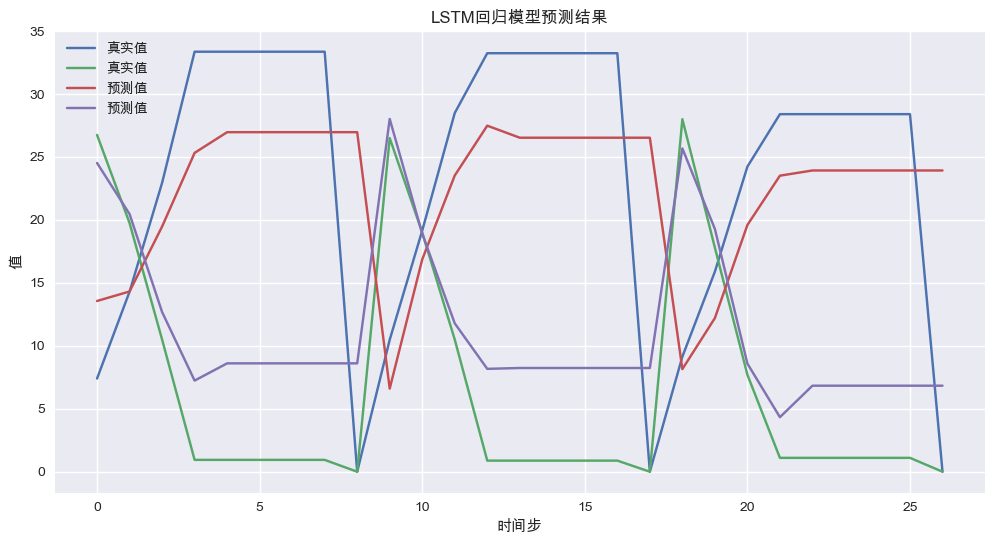

In [123]:
test_lstm_model()